In [1]:
!pip install gshap

In [2]:
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import gshap
from gshap.datasets import load_recidivism

recid = load_recidivism()
X, y = recid.data, recid.target

In [3]:
print(X.columns.tolist())

['male', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'felony', 'black', 'married', 'high_supervision']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_mlp(X_train.shape[1])
print("Model training...")
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))
print("Model training completed!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model training...
Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6036 - loss: 0.6537 - val_accuracy: 0.6770 - val_loss: 0.6032
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6591 - loss: 0.6154 - val_accuracy: 0.6750 - val_loss: 0.6007
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6667 - loss: 0.6147 - val_accuracy: 0.6760 - val_loss: 0.5972
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6562 - loss: 0.6224 - val_accuracy: 0.6750 - val_loss: 0.5995
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6632 - loss: 0.6198 - val_accuracy: 0.6820 - val_loss: 0.5972
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6725 - loss: 0.6125 - val_accuracy: 0.6800 - val_loss: 0.5982
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6781 - loss: 0.6015 - val_accuracy: 0.6770 - val_loss: 0.5989
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6764 - loss: 0.6105

  0%|          | 0/100 [00:00<?, ?it/s]

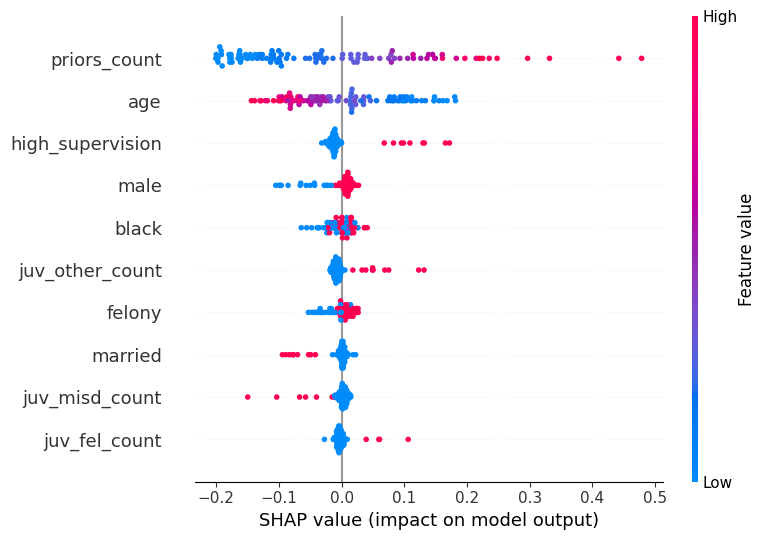

In [6]:
def predict_fn(X_numpy):
    return model(X_numpy, training=False).numpy().flatten()

explainer = shap.KernelExplainer(predict_fn, X_train_scaled[:50])
shap_values = explainer.shap_values(X_test_scaled[:100], nsamples=50)

shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=X.columns)

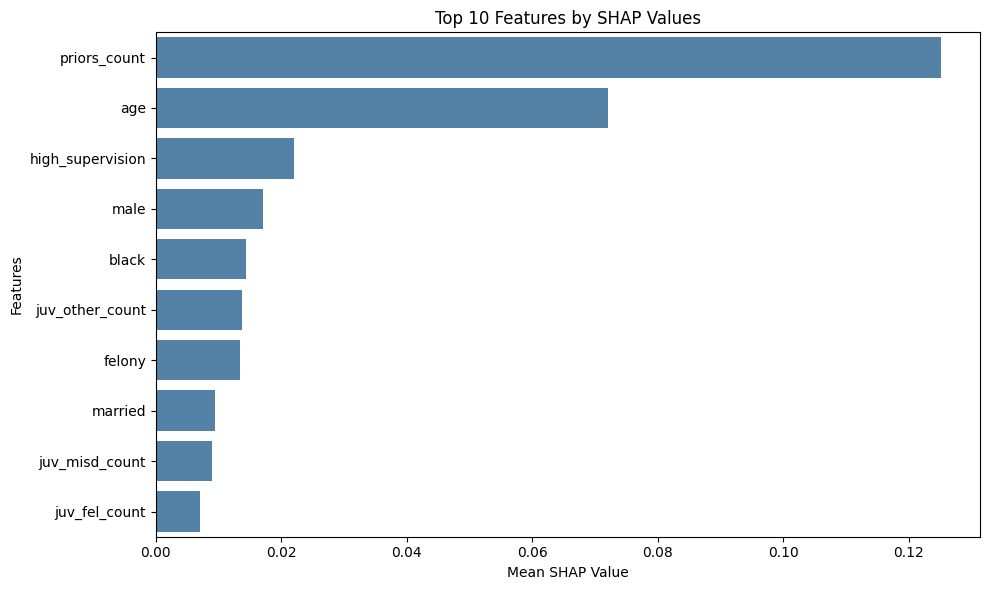


SHAP Table (Top Features):


,Features,Mean SHAP Value
5,priors_count,0.125064
1,age,0.072109
9,high_supervision,0.021986
0,male,0.017104
7,black,0.014426
4,juv_other_count,0.013774
6,felony,0.013369
8,married,0.009387
3,juv_misd_count,0.008893
2,juv_fel_count,0.007034


In [7]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
df_importance = pd.DataFrame({'Features': X.columns, 'Mean SHAP Value': mean_abs_shap})
df_importance = df_importance.sort_values('Mean SHAP Value', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='Features', x='Mean SHAP Value', data=df_importance.head(20), color='steelblue')
plt.title("Top 10 Features by SHAP Values")
plt.xlabel("Mean SHAP Value")
plt.tight_layout()
plt.show()

print("\nSHAP Table (Top Features):")
display(df_importance.head(20))